In [1]:
import os

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import tensorflow as tf

if os.getcwd().split(os.sep)[-1] == 'notebook':
    os.chdir('..')

from cma import CMA
from notebook.utils import (
    plot_3d_surface,
    plot_2d_contour,
    plot_generations,
    draw_confidence_ellipse,
    plot_mean_coordinates,
)

In [2]:
tf.random.set_seed(444)  # set random seed for reproducibility

# Optimisation of the Six-Hump Camel Function

Using the Covariance Matrix Adaptation Evolution Strategy (CMA-ES)

## 1. Define & visualize the fitness function

In [3]:
def fitness_fn(x):
    """
    Six-Hump Camel Function
    https://www.sfu.ca/~ssurjano/camel6.html
    """
    return (
        (4 - 2.1 * x[:,0]**2 + x[:,0]**4 / 3) * x[:,0]**2 +
        x[:,0] * x[:,1] +
        (-4 + 4 * x[:,1]**2) * x[:,1]**2
    )

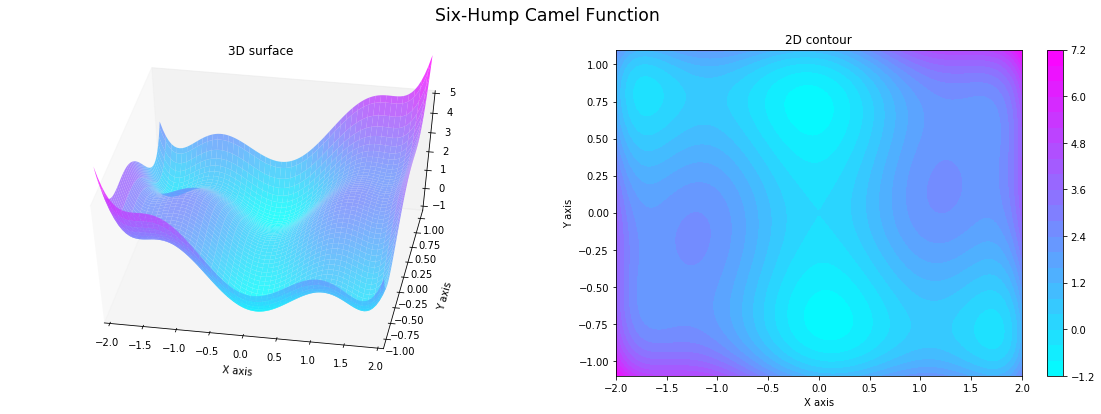

In [4]:
fig = plt.figure(figsize=(20, 6))
gs = mpl.gridspec.GridSpec(1, 2, figure=fig)
ax1 = fig.add_subplot(gs[0,0], projection='3d')
ax2 = fig.add_subplot(gs[0,1])

plot_3d_surface(
    fitness_fn,
    xlim=[-2, 2], 
    ylim=[-1.1, 1.1],
    zlim=[-1.1, 5],
    view_init=[50, -80],
    fig=fig,
    ax=ax1,
);
ax1.set_xlabel('\nX axis');
ax1.set_ylabel('\n\nY axis');
ax1.set_title('3D surface\n');

plot_2d_contour(
    fitness_fn,
    xlim=[-2, 2], 
    ylim=[-1.1, 1.1],
    fig=fig,
    ax=ax2,
);
ax2.set_title('2D contour');
fig.patch.set_facecolor('white');
fig.suptitle('Six-Hump Camel Function\n', fontsize='xx-large');

The global minimum value is `-1.0316` at `x = [0.0898, -0.7126]` and `x = [-0.0898, 0.7126]`.

## 2. Configure the CMA class & run the search

The initial solution and initial step size (i.e. initial standard deviation of the search normal distribution) are problem specific.

We are setting the `store_trace` parameter to `True` in order to keep track of the key variables at each generation. This will be useful to visualize the search after completion.

In [5]:
cma = CMA(
    initial_solution=[1.5, -0.4],
    initial_step_size=1.0,
    fitness_function=fitness_fn,
    store_trace=True,
)
cma.search();

In [6]:
best_solution = cma.best_solution()
best_fitness = cma.best_fitness()

print('Number of generations:', len(cma.trace))
print('Best solution:', best_solution)
print('Best fitness:', best_fitness)

Number of generations: 74
Best solution: [ 0.08984201 -0.71265641]
Best fitness: -1.0316284534898772


The search ran for 74 generations before settling down for the global maximum at `[0.08984201 -0.71265641]`.

## 3. Visualize the search trace

### 3.1 Evolution of the best solution coordinates

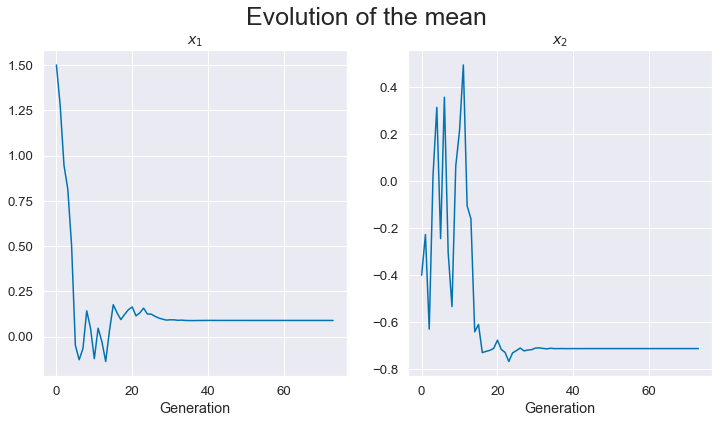

In [7]:
sns.set(palette='colorblind', font_scale=1.2)

means = np.vstack([t['m'] for t in cma.trace])
plot_mean_coordinates(means);

Looks like the best value converged around generation 25. Early stopping rules then kicked in a few generations later.

### 3.2 Plot a few generations

- The cross represents the mean (i.e. best solution at current generation)
- The white dots with border are the best solution, which will be used to update the variables
- The white dots without border are the worts solutions, which are discarded.
- The ellipse is the 2-σ confidence, i.e. 95% of the generated points will fall within the ellipse

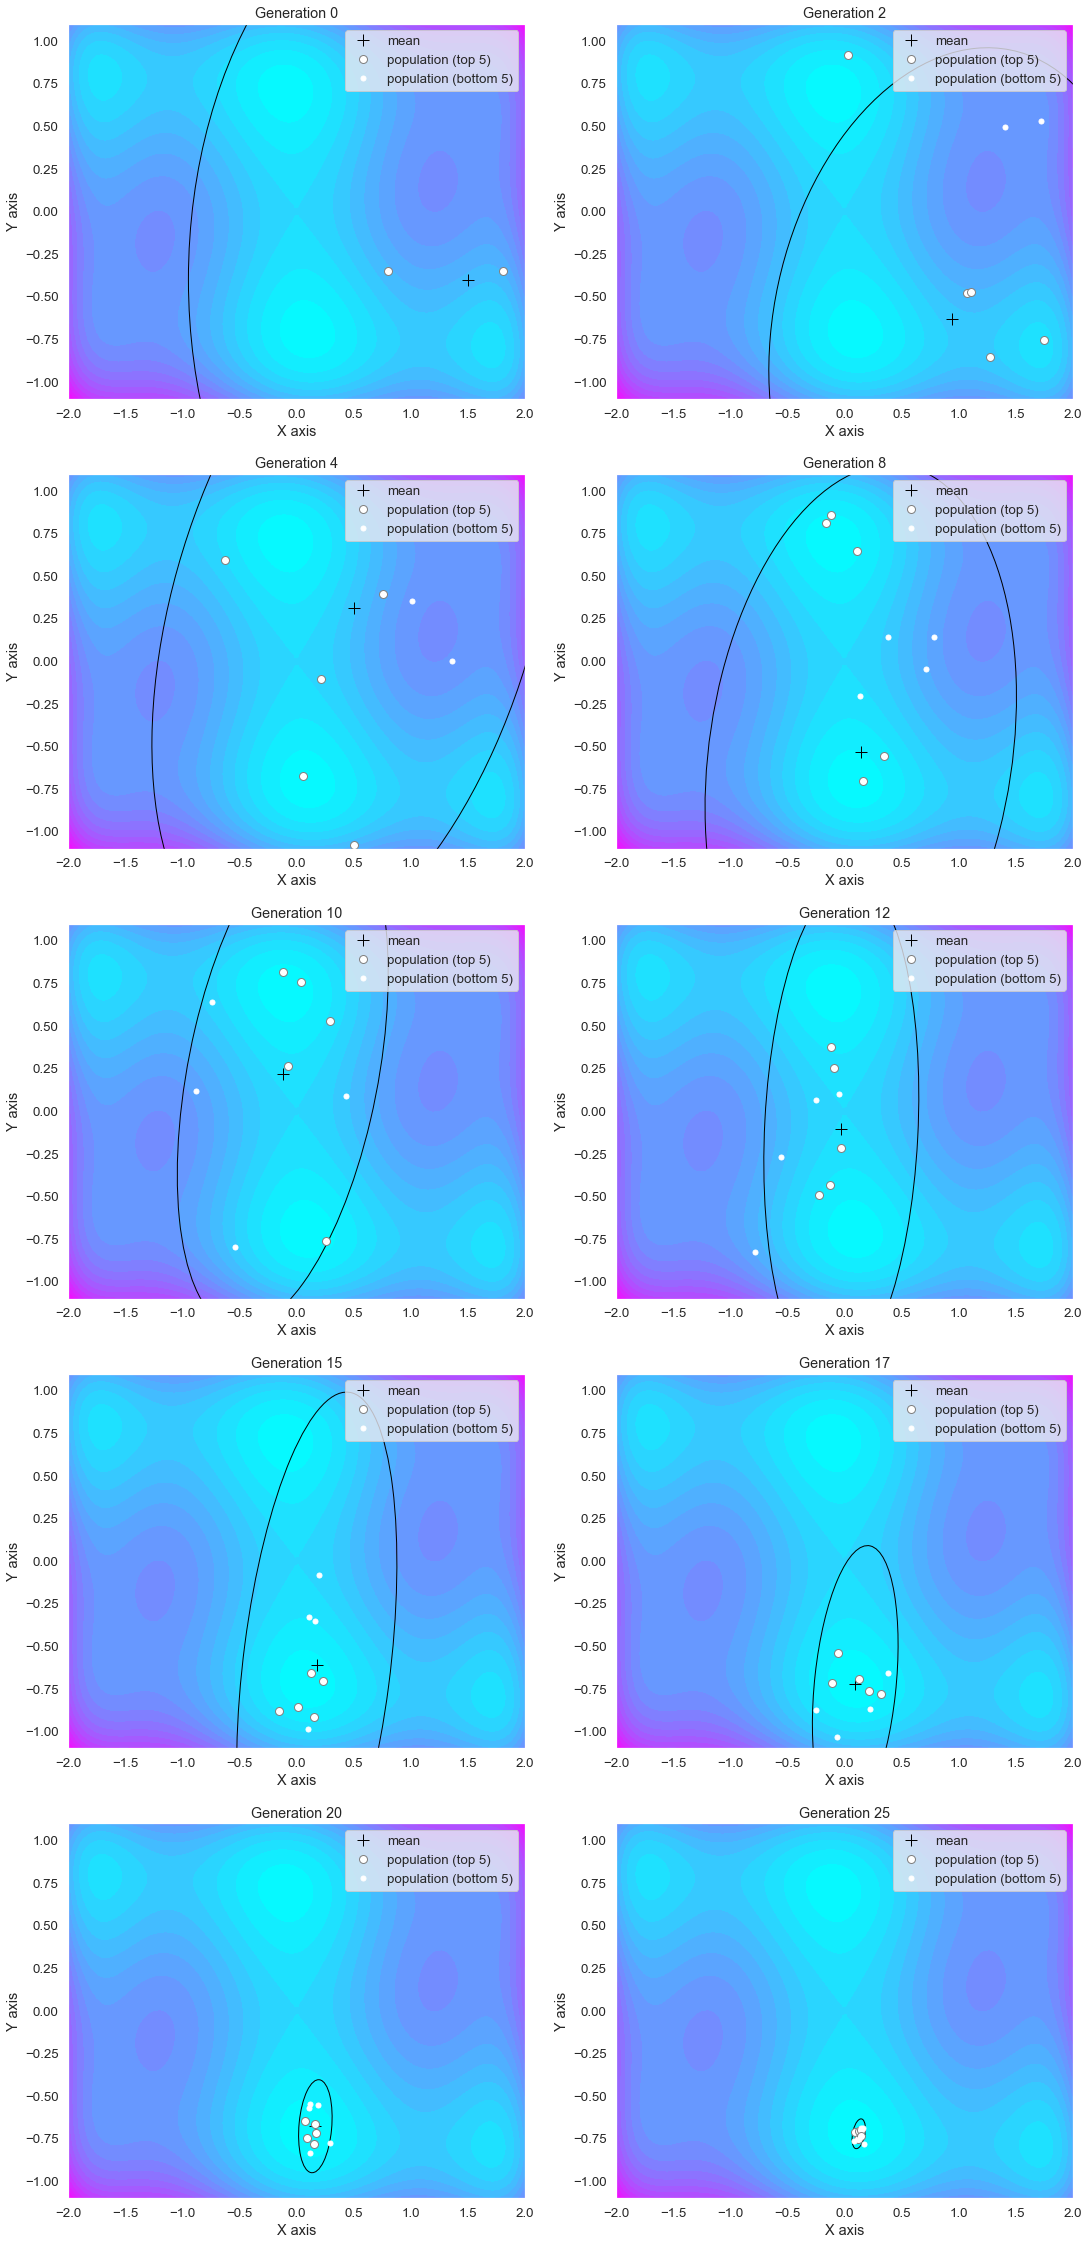

In [8]:
generations = [0, 2, 4, 8, 10, 12, 15, 17, 20, 25]
plot_generations(
    generations,
    cma.trace,
    fitness_fn,
    xlim=[-2, 2], 
    ylim=[-1.1, 1.1],
);